- Objective: Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.
- Source - https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113
- Considering the models applied I found that Ada-Boost with Logistic Regression gave the best f1 score of 63%. 

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import association_metrics as am
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency
#from python.nominal import associations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score,classification_report,mean_squared_error
#from pyod.models.knn import KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
#from scikitplot.metrics import plot_cumulative_gain as pcg
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.ensemble import AdaBoostClassifier

# Reading and checking data 

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

# Describe the Data

In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
df.describe(include='object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,1448-PWKYE,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


# Checking for Null value

In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Dropping Customer ID column as not required

In [7]:
df.drop('customerID',axis=1,inplace=True)

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [9]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Dropping NA values as it is less tha 5% of the data

In [10]:
df.dropna(axis=0,inplace=True)
df.shape

(7032, 20)

In [11]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Checking the Target Value

In [12]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [13]:
# Counting percentages of 0
count_zero = (df['Churn'].value_counts()[0]/len(df['Churn']))*100
round(count_zero)

73

In [14]:
# Couning perventages of 1
count_one = (df['Churn'].value_counts()[1]/len(df['Churn']))*100
round(count_one)

27

# Checking Collinearity in the data 

### Cramer's V rule

In [15]:
df = df.apply(
    lambda x : x.astype('category') if x.dtype == 'O' else x
)

cramers_v = am.CramersV(df)

cfit = cramers_v.fit().round(2)
cfit

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
gender,1.00,0.00,0.01,0.01,0.01,0.01,0.02,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.01
Partner,0.00,1.00,0.45,0.02,0.14,0.00,0.15,0.15,0.17,0.13,0.14,0.13,0.30,0.01,0.16,0.15
Dependents,0.01,0.45,1.00,0.00,0.03,0.18,0.19,0.16,0.16,0.18,0.15,0.14,0.24,0.11,0.15,0.16
PhoneService,0.01,0.02,0.00,1.00,1.00,0.45,0.18,0.17,0.17,0.18,0.18,0.18,0.00,0.02,0.01,0.01
MultipleLines,0.01,0.14,0.03,1.00,1.00,0.40,0.23,0.25,0.25,0.23,0.26,0.26,0.08,0.17,0.17,0.04
InternetService,0.01,0.00,0.18,0.45,0.40,1.00,0.72,0.71,0.71,0.72,0.72,0.72,0.21,0.38,0.31,0.32
OnlineSecurity,0.02,0.15,0.19,0.18,0.23,0.72,1.00,0.72,0.72,0.73,0.71,0.71,0.30,0.34,0.30,0.35
OnlineBackup,0.01,0.15,0.16,0.17,0.25,0.71,0.72,1.00,0.72,0.72,0.71,0.71,0.26,0.32,0.28,0.29
DeviceProtection,0.00,0.17,0.16,0.17,0.25,0.71,0.72,0.72,1.00,0.73,0.73,0.74,0.30,0.32,0.29,0.28
TechSupport,0.01,0.13,0.18,0.18,0.23,0.72,0.73,0.72,0.73,1.00,0.72,0.72,0.33,0.33,0.31,0.34


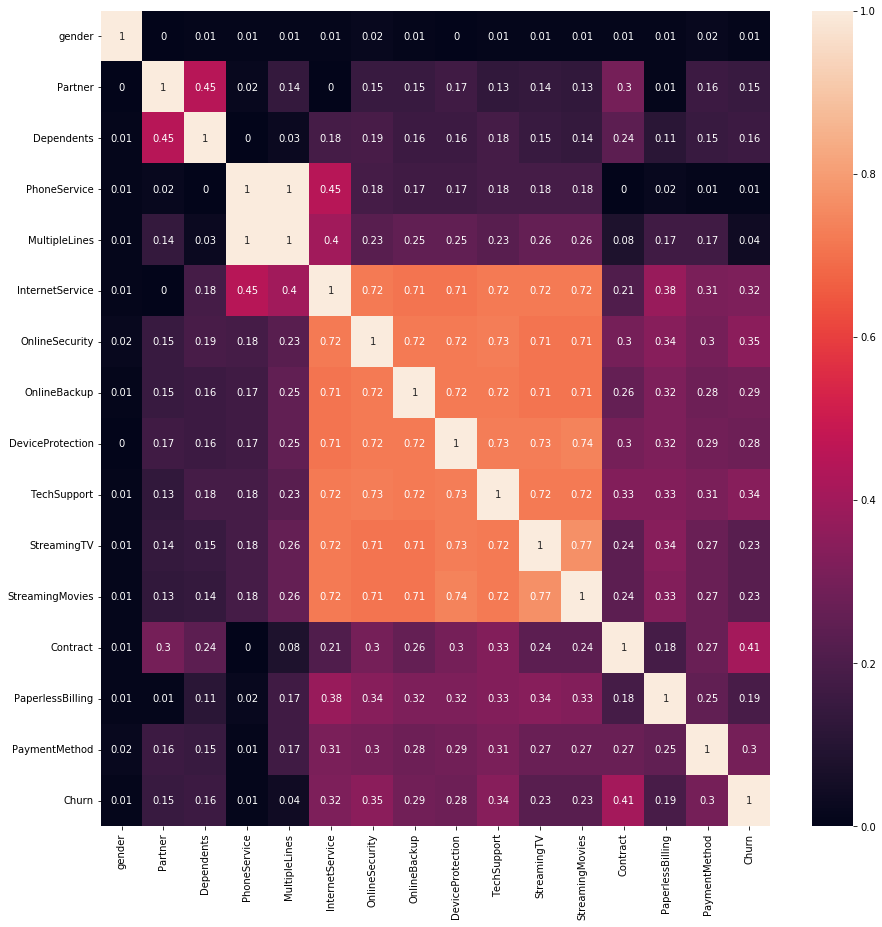

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(cramers_v.fit().round(2),annot=True)

In [17]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


In [18]:
df['Churn'] = df.Churn.map({'No':0,'Yes':1})
df['Churn'] = df['Churn'].astype('int64')

In [19]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [20]:
b,a = dmatrices('Churn ~ SeniorCitizen + tenure + MonthlyCharges + TotalCharges',data=df,return_type='dataframe')

vif  = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
vif['variable'] = a.columns

vif

,VIF,variable
0,14.989702,Intercept
1,1.054455,SeniorCitizen
2,5.847215,tenure
3,3.314481,MonthlyCharges
4,9.543891,TotalCharges


### Dropping the TotalCharges as having high VIF

In [21]:
df = df.drop('TotalCharges',axis=1)

# Checking the Distribution

In [22]:
features = []

for i in df.columns:
    unique_values = df[i].nunique()  
    if unique_values < 5:
        features.append(i)
features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [23]:
features.remove('Churn')

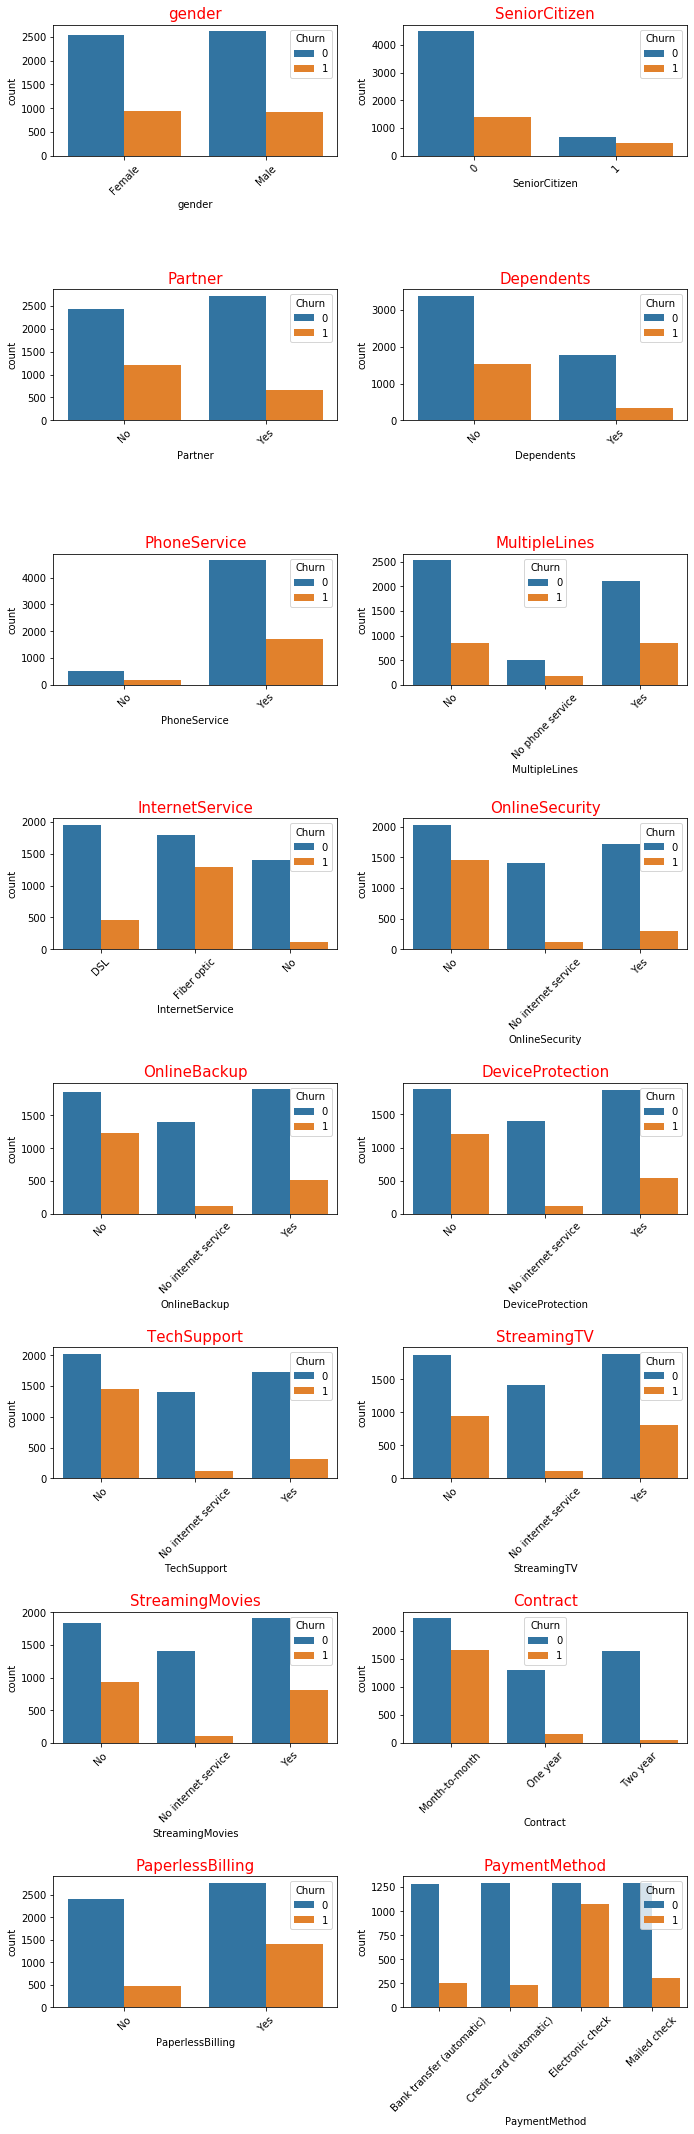

In [24]:
plt.figure(figsize=(10, 30))

for i, column in enumerate(features):
    plt.subplot((len(features) + 1) // 2, 2, i + 1)  

    sns.countplot(data=df, x=column, hue="Churn")

    plt.title(column, fontsize = 15, color = "red")
    plt.xticks(rotation=45)

plt.tight_layout(pad=2.0)
plt.show()

In [25]:
categorical_cols = df.select_dtypes(exclude = np.number).columns.tolist()
numerical_cols = df.select_dtypes(include = np.number).columns.tolist()

In [26]:
length= len(categorical_cols)
length

15

In [27]:
df.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,1
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,1
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,0
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,0
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,1
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,0


In [28]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
Churn                  2
dtype: int64

In [29]:
df.info()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

# Dummification of the Multiclass Categorical fields

In [30]:
features = df.drop('Churn',axis=1)
tg = df['Churn']

for i in features:
    if df[i].dtypes == 'category':
        woe = (pd.crosstab(df[i],tg,normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0])).assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
        print(woe)

Churn          0         1       woe        iv
gender                                        
Female  0.492737  0.502408  0.019437  0.000374
Male    0.507263  0.497592 -0.019249  0.000374
Churn         0         1       woe        iv
Partner                                      
No       0.4724  0.642055  0.306848  0.117877
Yes      0.5276  0.357945 -0.387958  0.117877
Churn              0         1       woe        iv
Dependents                                        
No          0.656595  0.825575  0.229013  0.153169
Yes         0.343405  0.174425 -0.677417  0.153169
Churn               0         1       woe        iv
PhoneService                                       
No            0.09878  0.090958 -0.082498  0.000713
Yes           0.90122  0.909042  0.008642  0.000713
Churn                    0         1       woe        iv
MultipleLines                                           
No                0.491187  0.454254 -0.078170  0.008169
No phone service  0.098780  0.090958 -0.08249

In [31]:
for i in features:
    if df[i].dtypes == 'category':
        woe = (pd.crosstab(df[i],tg,normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0])).assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
        woe_dict = woe['woe'].to_dict()
        df = df.replace({i: woe_dict})

In [32]:
df.head(15)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0.019437,0,-0.387958,0.229013,1,-0.082498,-0.082498,-0.434003,0.684248,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,29.85,0
1,-0.019249,0,0.306848,0.229013,34,0.008642,-0.078170,-0.434003,-0.746990,0.608219,-0.218397,0.678852,0.332031,0.340714,-1.046622,-0.614421,-0.420824,56.95,0
2,-0.019249,0,0.306848,0.229013,2,0.008642,-0.078170,-0.434003,-0.746990,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,-0.420824,53.85,1
3,-0.019249,0,0.306848,0.229013,45,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,-0.218397,-0.703190,0.332031,0.340714,-1.046622,-0.614421,-0.588662,42.30,0
4,0.019437,0,0.306848,0.229013,2,0.008642,-0.078170,0.688937,0.684248,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,70.70,1
5,0.019437,0,0.306848,0.229013,8,0.008642,0.103595,0.688937,0.684248,0.608219,-0.218397,0.678852,0.174272,0.166549,0.722408,0.334461,0.826969,99.65,1
6,-0.019249,0,0.306848,-0.677417,22,0.008642,0.103595,0.688937,0.684248,-0.274966,0.574694,0.678852,0.174272,0.340714,0.722408,0.334461,-0.698770,89.10,0
7,0.019437,0,0.306848,0.229013,10,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,-0.614421,-0.420824,29.75,0
8,0.019437,0,-0.387958,0.229013,28,0.008642,0.103595,0.688937,0.684248,0.608219,-0.218397,-0.703190,0.174272,0.166549,0.722408,0.334461,0.826969,104.80,1
9,-0.019249,0,0.306848,-0.677417,62,0.008642,-0.078170,-0.434003,-0.746990,-0.274966,0.574694,0.678852,0.332031,0.340714,-1.046622,-0.614421,-0.588662,56.15,0


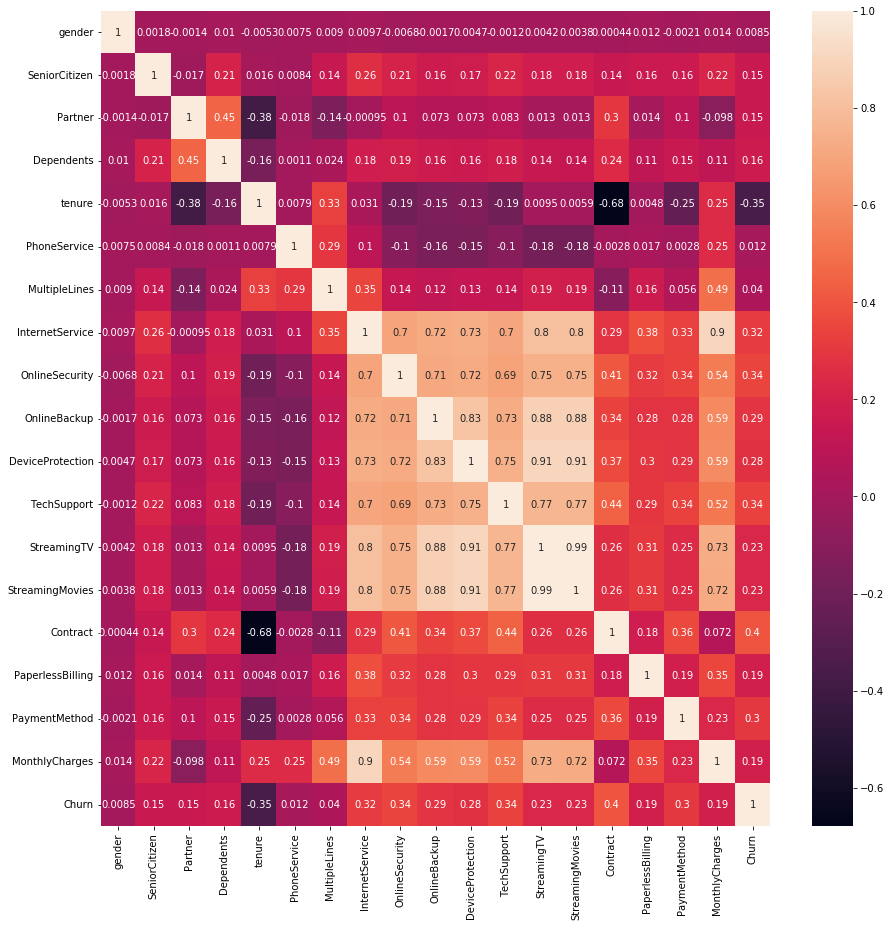

In [33]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

In [34]:
features_to_pca = ["InternetService","OnlineBackup","DeviceProtection","StreamingTV","StreamingMovies",]

In [35]:
df_pca = df[features_to_pca]

In [36]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca)


result = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
result

,PC1,PC2
0,-0.552923,0.516952
1,-0.596110,0.591468
2,-0.552923,0.516952
3,-0.596110,0.591468
4,-1.469855,-0.160575
...,...,...
7027,-0.451888,0.548322
7028,-0.564399,-0.737231
7029,-0.955134,0.820965
7030,-1.469855,-0.160575


In [37]:
df = df.drop(columns=features_to_pca)

In [38]:
df = pd.concat([df, result], axis=1)

In [39]:
df.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,PC1,PC2
0,0.019437,0.0,-0.387958,0.229013,1.0,-0.082498,-0.082498,0.684248,0.678852,0.722408,0.334461,0.826969,29.85,0.0,-0.552923,0.516952
1,-0.019249,0.0,0.306848,0.229013,34.0,0.008642,-0.078170,-0.746990,0.678852,-1.046622,-0.614421,-0.420824,56.95,0.0,-0.596110,0.591468
2,-0.019249,0.0,0.306848,0.229013,2.0,0.008642,-0.078170,-0.746990,0.678852,0.722408,0.334461,-0.420824,53.85,1.0,-0.552923,0.516952
3,-0.019249,0.0,0.306848,0.229013,45.0,-0.082498,-0.082498,-0.746990,-0.703190,-1.046622,-0.614421,-0.588662,42.30,0.0,-0.596110,0.591468
4,0.019437,0.0,0.306848,0.229013,2.0,0.008642,-0.078170,0.684248,0.678852,0.722408,0.334461,0.826969,70.70,1.0,-1.469855,-0.160575
5,0.019437,0.0,0.306848,0.229013,8.0,0.008642,0.103595,0.684248,0.678852,0.722408,0.334461,0.826969,99.65,1.0,-0.966609,-0.433218
6,-0.019249,0.0,0.306848,-0.677417,22.0,0.008642,0.103595,0.684248,0.678852,0.722408,0.334461,-0.698770,89.10,0.0,-0.999121,-0.484846
7,0.019437,0.0,0.306848,0.229013,10.0,-0.082498,-0.082498,-0.746990,0.678852,0.722408,-0.614421,-0.420824,29.75,0.0,-0.955134,0.820965
8,0.019437,0.0,-0.387958,0.229013,28.0,0.008642,0.103595,0.684248,-0.703190,0.722408,0.334461,0.826969,104.80,1.0,-0.966609,-0.433218
9,-0.019249,0.0,0.306848,-0.677417,62.0,0.008642,-0.078170,-0.746990,0.678852,-1.046622,-0.614421,-0.588662,56.15,0.0,-0.552923,0.516952


In [40]:
df.isnull().sum()

gender              11
SeniorCitizen       11
Partner             11
Dependents          11
tenure              11
PhoneService        11
MultipleLines       11
OnlineSecurity      11
TechSupport         11
Contract            11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
Churn               11
PC1                 11
PC2                 11
dtype: int64

In [41]:
df.dropna(axis=0,inplace=True)
df.shape

(7021, 16)

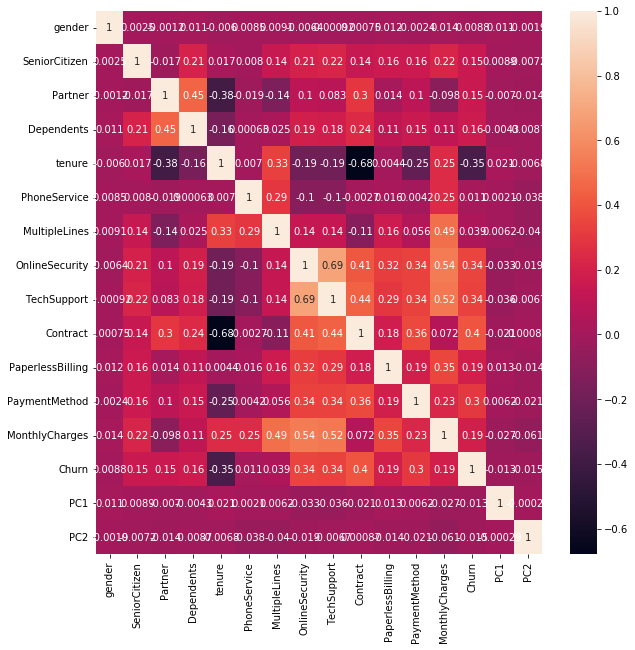

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

# Checking the Information Value

In [43]:
for i in features:
    if features[i].dtypes == 'category':
        woe = (pd.crosstab(features[i],tg,normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0])).assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
        print(woe['iv'])
#woe

gender
Female    0.000374
Male      0.000374
Name: iv, dtype: float64
Partner
No     0.117877
Yes    0.117877
Name: iv, dtype: float64
Dependents
No     0.153169
Yes    0.153169
Name: iv, dtype: float64
PhoneService
No     0.000713
Yes    0.000713
Name: iv, dtype: float64
MultipleLines
No                  0.008169
No phone service    0.008169
Yes                 0.008169
Name: iv, dtype: float64
InternetService
DSL            0.615253
Fiber optic    0.615253
No             0.615253
Name: iv, dtype: float64
OnlineSecurity
No                     0.715292
No internet service    0.715292
Yes                    0.715292
Name: iv, dtype: float64
OnlineBackup
No                     0.526488
No internet service    0.526488
Yes                    0.526488
Name: iv, dtype: float64
DeviceProtection
No                     0.49761
No internet service    0.49761
Yes                    0.49761
Name: iv, dtype: float64
TechSupport
No                     0.697108
No internet service    0.697108
Yes    

# Splitting Predictors and Target

In [44]:
X = df.drop('Churn',axis=1)
y = df['Churn']

Important: PaymentMethod,StreamingMovies,StreamingTV,DeviceProtection

Suspicious: Contract,TechSupport, OnlineBackup, OnlineSecurity, InternetService

Medium: PaperlessBilling, Dependents, Partner

Weak: 

Useless: MultipleLines, PhoneService, gender

# Feature Selection

In [45]:
etr_model = ExtraTreesRegressor()
etr_model.fit(X,y)
etr_model.feature_importances_

array([0.04106374, 0.02883165, 0.03602751, 0.03049593, 0.16150545,
       0.01085081, 0.03014971, 0.06012934, 0.03631315, 0.1322979 ,
       0.02940599, 0.05971549, 0.16263703, 0.08767315, 0.09290316])

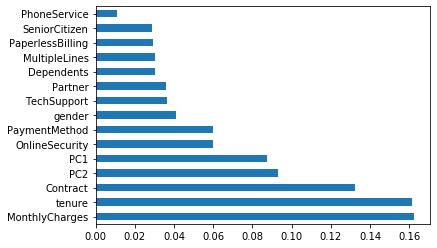

In [46]:
feature_imp = pd.Series(etr_model.feature_importances_,index=X.columns)
feature_imp.nlargest(20).plot(kind='barh')

In [47]:
feature = ['Contract','tenure','PaymentMethod','MonthlyCharges','PC1','PC2','Partner','Dependents']

In [48]:
X = df[feature]

In [49]:
X = df.drop('Churn',axis=1)
y = df['Churn']

# Performing Train Test Split

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=101)

# Scaling the data 

In [51]:
sc = StandardScaler()

In [52]:
X_train = pd.DataFrame(sc.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),columns=X_test.columns)

# Logistic regression

In [53]:
model_lr = LogisticRegression(multi_class='ovr',penalty='l2',max_iter=2000,random_state=101)

In [54]:
np.mean(cross_val_score(model_lr,X_train,y_train,cv=5))

0.7950504336693465

In [55]:
model_lr.fit(X_train,y_train)

LogisticRegression(max_iter=2000, multi_class='ovr', random_state=101)

In [56]:
f1_score(y_train,model_lr.predict(X_train))

0.5811155668975574

In [57]:
y_pred_lr = model_lr.predict(X_test)

In [58]:
model_lr.score(X_test,y_test)

0.8192170818505338

In [59]:
f1_score(y_test,y_pred_lr)

0.6151515151515151

In [60]:
cm = confusion_matrix(y_test,y_pred_lr)

In [61]:
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

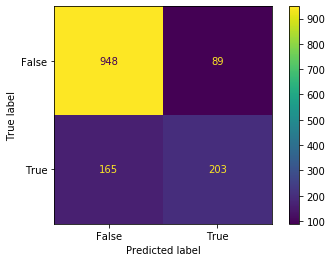

In [62]:
cm_display_lr.plot()
plt.show()

In [63]:
auc_score = roc_auc_score(y_test,y_pred_lr)
auc_score

0.7329029705253448

In [64]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      1037
         1.0       0.70      0.55      0.62       368

    accuracy                           0.82      1405
   macro avg       0.77      0.73      0.75      1405
weighted avg       0.81      0.82      0.81      1405



In [65]:
probs = model_lr.predict_proba(X_test)

In [66]:
pcg(y_test,probs)
plt.show()

NameError: name 'pcg' is not defined

In [67]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [68]:
grid_search = GridSearchCV(model_lr, param_grid, cv=5, scoring='accuracy')

In [69]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=2000, multi_class='ovr',
                                          random_state=101),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [70]:
grid_search.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [71]:
grid_search.best_score_

0.7950504336693465

In [72]:
best_model = grid_search.best_estimator_

In [73]:
test_accuracy = best_model.score(X_test, y_test)
test_accuracy

0.8177935943060498

In [74]:
f1_score(y_train,best_model.predict(X_train))

0.5826656955571741

In [75]:
y_pred_lr1 = best_model.predict(X_test)

In [76]:
auc_score = roc_auc_score(y_test,y_pred_lr1)
auc_score

0.732815185946082

In [77]:
print(classification_report(y_test, y_pred_lr1))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      1037
         1.0       0.69      0.55      0.61       368

    accuracy                           0.82      1405
   macro avg       0.77      0.73      0.75      1405
weighted avg       0.81      0.82      0.81      1405



In [78]:
probs_grid = best_model.predict_proba(X_test)

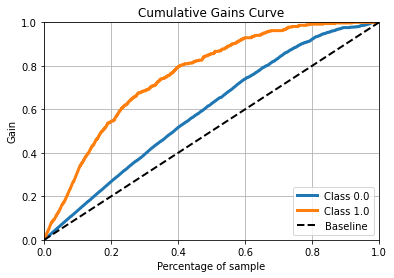

In [79]:
pcg(y_test,probs_grid)
plt.show()

# KNN Classification

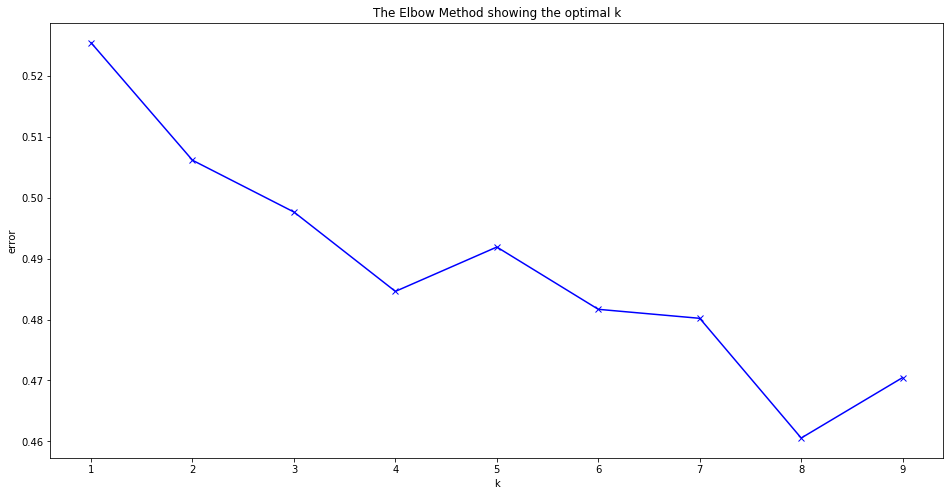

In [79]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred_KNN = knn.predict(X_test)
    error.append(np.sqrt(mean_squared_error(y_test, y_pred_KNN)))

plt.figure(figsize=(16,8))
plt.plot(range(1, 10), error, 'bx-')
plt.xlabel('k')
plt.ylabel('error')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [80]:
model_knn = KNeighborsClassifier(n_neighbors = 5)

In [81]:
model_knn.fit(X_train,y_train)

KNeighborsClassifier()

In [82]:
np.mean(cross_val_score(model_knn,X_train,y_train,cv=5))

0.7553404549963082

In [83]:
f1_score(y_train,model_knn.predict(X_train))

0.6614509246088194

In [84]:
y_pred_knn = model_knn.predict(X_test)

In [85]:
y_test.value_counts()

0.0    1037
1.0     368
Name: Churn, dtype: int64

In [86]:
f1_score(y_test,y_pred_knn)

0.5086705202312138

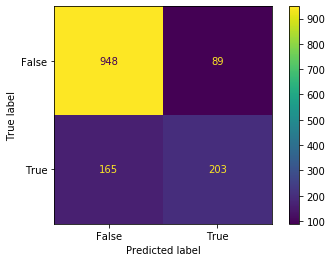

In [87]:
cm = confusion_matrix(y_test,y_pred_lr)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [88]:
auc_score = roc_auc_score(y_test,y_pred_knn)
auc_score

0.667770743365058

In [89]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84      1037
         1.0       0.54      0.48      0.51       368

    accuracy                           0.76      1405
   macro avg       0.68      0.67      0.67      1405
weighted avg       0.75      0.76      0.75      1405



# DecisionTree Classification

In [90]:
model_dt = DecisionTreeClassifier(max_depth=7,random_state=0)

In [91]:
np.mean(cross_val_score(model_dt,X_train,y_train,cv=5))

0.7751057633499492

In [92]:
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7, random_state=0)

In [93]:
f1_score(y_train,model_dt.predict(X_train))

0.6565758493104609

In [94]:
y_pred_dt = model_dt.predict(X_test)

In [95]:
f1_score(y_test,y_pred_dt)

0.6096551724137931

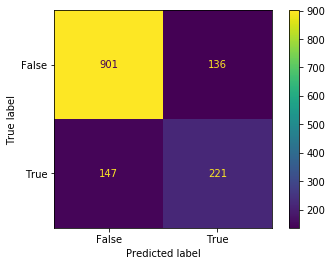

In [96]:
cm = confusion_matrix(y_test,y_pred_dt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [97]:
auc_score = roc_auc_score(y_test,y_pred_dt)
auc_score

0.7346979686386316

In [98]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1037
         1.0       0.62      0.60      0.61       368

    accuracy                           0.80      1405
   macro avg       0.74      0.73      0.74      1405
weighted avg       0.80      0.80      0.80      1405



In [99]:
probs = model_dt.predict_proba(X_test)

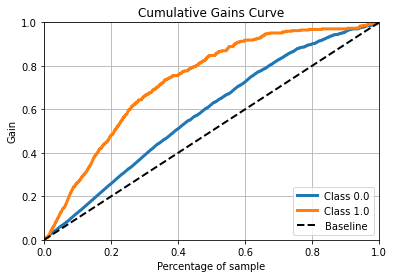

In [101]:
pcg(y_test,probs)
plt.show()

# Random Forest Classification

In [100]:
model_rf = RandomForestClassifier(max_depth=11,random_state=0)

In [101]:
np.mean(cross_val_score(model_rf,X_train,y_train,cv=5))

0.7952280527184745

In [102]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=11, random_state=0)

In [103]:
f1_score(y_train,model_rf.predict(X_train))

0.8566433566433567

In [104]:
y_pred_rf = model_rf.predict(X_test)

In [105]:
f1_score(y_test,y_pred_rf)

0.5805422647527911

In [106]:
auc_score = roc_auc_score(y_test,y_pred_rf)
auc_score

0.71015628275544

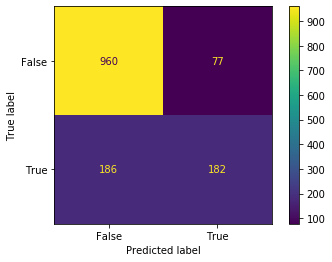

In [107]:
cm = confusion_matrix(y_test,y_pred_rf)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [108]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88      1037
         1.0       0.70      0.49      0.58       368

    accuracy                           0.81      1405
   macro avg       0.77      0.71      0.73      1405
weighted avg       0.80      0.81      0.80      1405



In [109]:
probs = model_rf.predict_proba(X_test)

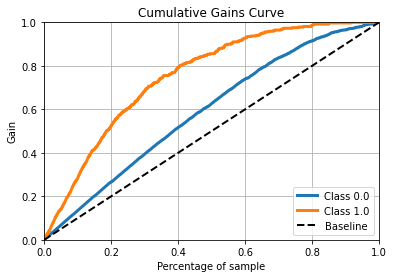

In [112]:
pcg(y_test,probs)
plt.show()

# Ada Boost on Logistic Regression

In [110]:
classifier = AdaBoostClassifier(
    LogisticRegression(multi_class='ovr',penalty='l2',max_iter=2000),
    n_estimators = 200
)

In [111]:
classifier.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=2000,
                                                     multi_class='ovr'),
                   n_estimators=200)

In [112]:
f1_score(y_train,classifier.predict(X_train))

0.5831517792302107

In [113]:
y_pred_ada = classifier.predict(X_test)

In [114]:
f1_score(y_test,y_pred_ada)

0.6304675716440422

# Applying SMOTE

In [115]:
smt = SMOTE(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [116]:
count_zero = (y_train.value_counts()[0]/len(y_train))*100
count_zero

50.0

In [117]:
count_one = (y_train.value_counts()[1]/len(y_train))*100
count_one

50.0

# Logistic Regression

In [118]:
model_lr_smt = LogisticRegression(multi_class='ovr',penalty='l2',max_iter=2000)

In [119]:
np.mean(cross_val_score(model_lr_smt,X_train,y_train,cv=5))

0.7685784244374886

In [120]:
model_lr_smt.fit(X_train,y_train)

LogisticRegression(max_iter=2000, multi_class='ovr')

In [121]:
f1_score(y_train,model_lr_smt.predict(X_train))

0.7783708517057322

In [122]:
y_pred_lr_smt = model_lr_smt.predict(X_test)

In [123]:
f1_score(y_test,y_pred_lr_smt)

0.6267682263329706

In [124]:
auc_score = roc_auc_score(y_test,y_pred_lr_smt)
auc_score

0.7644962475367909

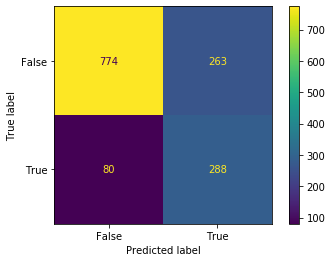

In [125]:
cm = confusion_matrix(y_test,y_pred_lr_smt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [126]:
print(classification_report(y_test, y_pred_lr_smt))

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82      1037
         1.0       0.52      0.78      0.63       368

    accuracy                           0.76      1405
   macro avg       0.71      0.76      0.72      1405
weighted avg       0.81      0.76      0.77      1405



In [127]:
probs = model_lr_smt.predict_proba(X_test)

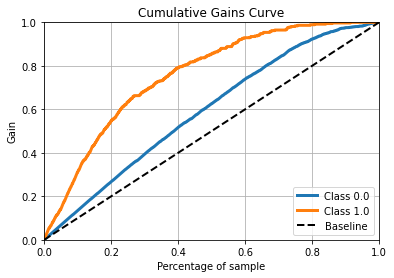

In [131]:
pcg(y_test,probs)
plt.show()

# KNN

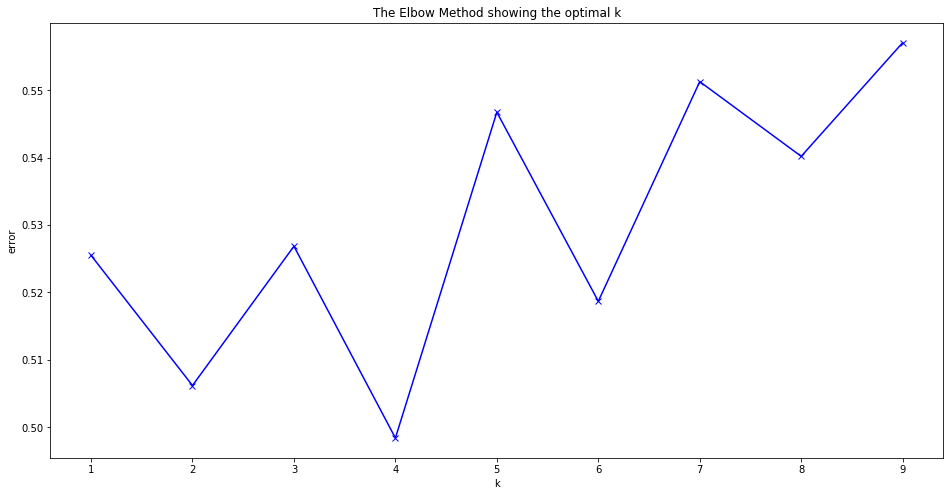

In [128]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred_KNN = knn.predict(X_test)
    error.append(np.sqrt(mean_squared_error(y_test, y_pred_KNN)))

plt.figure(figsize=(16,8))
plt.plot(range(1, 10), error, 'bx-')
plt.xlabel('k')
plt.ylabel('error')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [129]:
knn_smt = KNeighborsClassifier(n_neighbors = 4)

In [130]:
knn_smt.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [131]:
f1_score(y_train,knn_smt.predict(X_train))

0.895828367103695

In [132]:
y_pred_knn_smt = knn_smt.predict(X_test)

In [133]:
f1_score(y_test,y_pred_knn_smt)

0.5632040050062578

In [134]:
auc_score = roc_auc_score(y_test,y_pred_knn_smt)
auc_score

0.7063815458471343

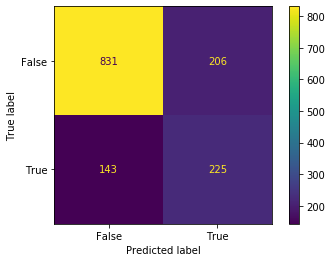

In [135]:
cm = confusion_matrix(y_test,y_pred_knn_smt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [136]:
print(classification_report(y_test, y_pred_knn_smt))

              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83      1037
         1.0       0.52      0.61      0.56       368

    accuracy                           0.75      1405
   macro avg       0.69      0.71      0.69      1405
weighted avg       0.77      0.75      0.76      1405



In [137]:
probs_knn_smt = knn_smt.predict_proba(X_test)

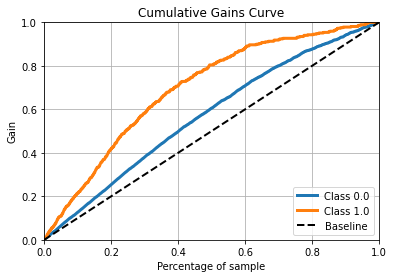

In [142]:
pcg(y_test,probs_knn_smt)
plt.show()

# Decision Tree

In [138]:
model_dt_smt = DecisionTreeClassifier(max_depth=5,random_state=0)

In [139]:
model_dt_smt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [140]:
f1_score(y_train,model_dt_smt.predict(X_train))

0.8050524308865585

In [141]:
model_dt_smt.get_depth()

5

In [142]:
y_pred_dt_smt = model_dt_smt.predict(X_test)

In [143]:
f1_score(y_test,y_pred_dt_smt)

0.6222222222222222

In [144]:
auc_score = roc_auc_score(y_test,y_pred_dt_smt)
auc_score

0.7548556664290804

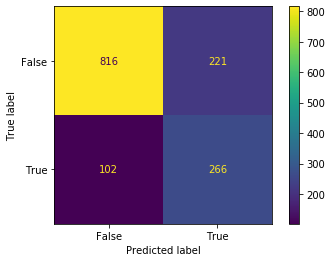

In [145]:
cm = confusion_matrix(y_test,y_pred_dt_smt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [146]:
print(classification_report(y_test, y_pred_lr_smt))

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82      1037
         1.0       0.52      0.78      0.63       368

    accuracy                           0.76      1405
   macro avg       0.71      0.76      0.72      1405
weighted avg       0.81      0.76      0.77      1405



In [147]:
probs_dt_smt = model_dt_smt.predict_proba(X_test)

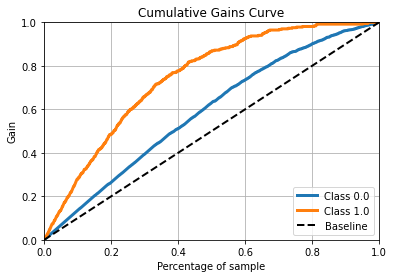

In [153]:
pcg(y_test,probs_dt_smt)
plt.show()

# RandomForest

In [148]:
model_rf_smt = RandomForestClassifier(max_depth=4,random_state=0)

In [149]:
model_rf_smt.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [150]:
f1_score(y_train,model_rf_smt.predict(X_train))

0.8005572324123521

In [151]:
y_pred_rd_smt = model_rf_smt.predict(X_test)

In [152]:
f1_score(y_test,y_pred_rd_smt)

0.6321709786276715

In [153]:
auc_score = roc_auc_score(y_test,y_pred_rd_smt)
auc_score

0.7660750597459227

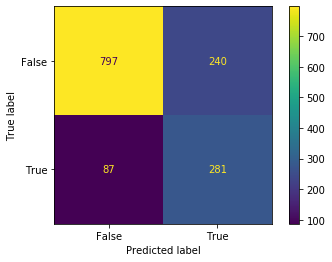

In [154]:
cm = confusion_matrix(y_test,y_pred_rd_smt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [155]:
print(classification_report(y_test, y_pred_rd_smt))

              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      1037
         1.0       0.54      0.76      0.63       368

    accuracy                           0.77      1405
   macro avg       0.72      0.77      0.73      1405
weighted avg       0.81      0.77      0.78      1405



In [156]:
probs_rf_smt = model_rf_smt.predict_proba(X_test)

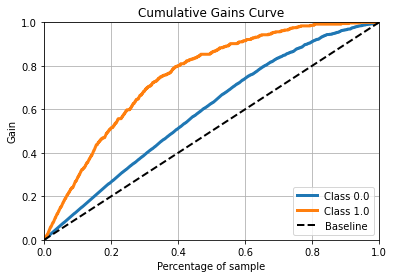

In [163]:
pcg(y_test,probs_rf_smt)
plt.show()

# Ada Boost

In [157]:
classifier = AdaBoostClassifier(
    LogisticRegression(multi_class='ovr',penalty='l2',max_iter=2000),
    n_estimators = 200
)

In [158]:
classifier.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=2000,
                                                     multi_class='ovr'),
                   n_estimators=200)

In [159]:
f1_score(y_train,classifier.predict(X_train))

0.7791907514450866

In [160]:
y_pred_ada_smt = classifier.predict(X_test)

In [161]:
f1_score(y_test,y_pred_ada_smt)

0.6270270270270271